In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.classify.maxent import MaxentClassifier
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import gc

from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from utils import Timer

In [4]:
df = pd.read_csv('../data/train_data_1.csv')

In [5]:
df_ = df[['phone_number','price_vnd']]

In [6]:
del df

In [7]:
df_

phone_number    price_vnd
0          929956939    1250000.0
1          835698567     750000.0
2          528898768     550000.0
3          834405505    1000000.0
4          368465111    1150000.0
...              ...          ...
356441     899658678    5500000.0
356442     913913355    4000000.0
356443     919821994    5500000.0
356444     768866555   10000000.0
356445     899999789  195000000.0

[356446 rows x 2 columns]

In [121]:
def creating_label(df):
    price = np.array(df['price_vnd'])
    label = []
    for i in range(df.shape[0]):
        # if price[i] <= 5e5:
        #     label.append(0)
        #     continue
        # if price[i] <= 1.5e6:
        #     label.append(1)
        #     continue
        if price[i] <= 3e6:
            label.append(2)
            continue
        # if price[i] <= 5e6:
        #     label.append(3)
        #     continue
        # if price[i] <= 1e7:
        #     label.append(4)
        #     continue
        # if price[i] <= 50e6:
        #     label.append(5)
        #     continue
        # if price[i] <= 1e8:
        #     label.append(6)
        #     continue
        # if price[i] <= 2e8:
        #     label.append(7)
        #     continue
        # if price[i] <= 5e8:
        #     label.append(8)
        #     continue

        label.append(6)

    df['label'] = label

    return df


In [122]:
def creating_label_2(df):
    price = np.array(df['price_vnd'])
    label = []
    for i in range(df.shape[0]):
        if price[i] <= 5e5:
            label.append(0)
            continue
        if price[i] <= 1.5e6:
            label.append(1)
            continue
        if price[i] <= 3e6:
            label.append(2)
            continue
        if price[i] <= 5e6:
            label.append(3)
            continue
        if price[i] <= 1e7:
            label.append(4)
            continue
        if price[i] <= 50e6:
            label.append(5)
            continue
        label.append(6)

    df['label_2'] = label

    return df


In [123]:
df_ = creating_label(df_)
df_ = creating_label_2(df_)

In [161]:
df_['label_2'].value_counts()

1    116830
2     80574
3     47962
4     37491
5     36857
0     24730
6     12002
Name: label_2, dtype: int64

In [160]:
df_label_2 = df_[(df_['label_2'] <= 3)]

In [162]:
df_label_2

phone_number  price_vnd  label  label_2
0         929956939  1250000.0      2        1
1         835698567   750000.0      2        1
2         528898768   550000.0      2        1
3         834405505  1000000.0      2        1
4         368465111  1150000.0      2        1
...             ...        ...    ...      ...
356430    799681992  3900000.0      6        3
356433    818222278  4500000.0      6        3
356439    852571571  4000000.0      6        3
356440    869666808  4600000.0      6        3
356442    913913355  4000000.0      6        3

[270096 rows x 4 columns]

In [14]:
# df_ = df_[(df_['label']==2) | (df_['label']==3)]

In [15]:
df_ = df_.astype({
    'phone_number': 'str'
})

In [16]:
df_ = df_[df_['phone_number'].str.len() == 9]

In [17]:
# df_label_high_2 = df_[df_['label'] > 1]
# df_label_1 = df_[df_['label'] == 1].sample(80000)
# df_label_0 = df_[df_['label'] == 0].sample(80000)

In [18]:
# df_data = pd.concat([df_label_0, df_label_1, df_label_high_2])
# del df_
# df_ = df_data
# df_.reset_index(inplace=True, drop=True)
# del df_data

In [19]:
df_['label'].value_counts()

5    344444
6     12002
Name: label, dtype: int64

In [128]:
VIETTEL_HEAD_NUMBER = ['032','033','034','035','037','038','039','086','096','097','098']
MOBI_HEAD_NUMBER = ['070','079','077','076','078','089','090','093']
VINA_HEAD_NUMBER = ['081','084','085','082','083','094','091','088']
VIETNAMMOBI_HEAD_NUMBER = ['056','058','092']
GMOBILE = ['059','099']

dict_list_combo = {
    'LIST_COMBO_6_LOWER_5': ['000000','111111','222222','333333','444444'],
    'LIST_COMBO_5_LOWER_4' : ['00000','11111','22222','33333'],
    'LIST_COMBO_5_EQUAL_4': ['44444'],
    'LIST_COMBO_4_LOWER_5 ':  ['0000','1111','2222','3333','4444'],
    'LIST_COMBO_3_LOWER_5' : ['000','111','222','333','444'],
    'LIST_COMBO_2_LOWER_5' :  ['00','11','22','33','44'],
    'LIST_COMBO_6_HIGHER_5': ['555555','666666','777777','999999','888888'],
    'LIST_COMBO_5_HIGHER_5':  ['55555','66666','77777','99999','88888'],
    'LIST_COMBO_4_HIGHER_5':  ['5555','6666','7777','9999','8888'],
    'LIST_COMBO_3_HIGHER_5':  ['555','666','777','999','888'],
    'LIST_COMBO_2_HIGHER_5': ['55','66','77','99','88'],
    'LIST_LUCKY_NUMBER' : ['68','86','79','38','83'],
    'LIST_5_INCREASING': ['01234','12345','23456','34567','45678','56789'],
    'LIST_5_INCREASING_2': ['02468','13579'],
    'LIST_4_INCREASING': ['0123','1234','2345','3456','4567','5678','6789'],
    'LIST_4_INCREASING_2' : ['0246','1357','2468','3579','0369'],
    'LIST_3_INCREASING': ['012','123','234','345','456','567','678','789'],
    'LIST_3_INCREASING_2': ['024','135','246','357','468','579','036','147','258','369','048','159'],
    'LIST_THAN_TAI': ['368379']
}

dict_than_tai_combo = {
    'LIST_COMBO_4_THAN_TAI' : ['7997', '8998','7799', '8899','9779', '9889','7979','3939','3579','1279'],
    'LIST_TAXI_NUMBER': ['04','47','07'],
    'LIST_COMBO_4_ONG_DIA': ['6666','3878'],
    'LIST_COMBO_3_ONG_DIA': ['138','238','338','438','538','638','738','838','938'],
    'LIST_COMBO_2_ONG_DIA': ['38','78'],
    'LIST_COMBO_2_THAN_TAI': ['39','79'],
    'LIST_COMBO_3_THAN_TAI' : ['179','579','279','679','979','079','479','879','379'],
    'LIST_COMBO_3_LOC_PHAT': ['6688','6868','6886', '8668'],
    'LIST_COMBO_2_LOC_PHAT': ['68','86','88','66'],
    'LIST_COMBO_SO_XAU': ['03','43','53','49','87','47']
}

LIST_COMBO_3_THAN_TAI = ['179','579','279','679','979','079','479','879','379']

In [130]:
class FeatureExtraction:
    def __init__(self):

        self.list_dai_cat = ['03','01','00','05','15','16','18','23','24','25','28','30','31','38','40','46','47','66','80','78']
        self.dict_index_have = {
            '0': False,
            '1': False,
            '2': False,
            '3': False,
            '4': False,
            '5': False,
            '6': False,
            '7': False,
            '8': False,
            '9': False
        }
        self.dict_index = {
            '0': False,
            '1': False,
            '2': False,
            '3': False,
            '4': False,
            '5': False,
            '6': False,
            '7': False,
            '8': False,
            '9': False
        }

    def preprocessing(self, number):
        _number = number
        if len(number) == 11:
            if number[0:2] == '84':
                _number = '0' + number[2:]
        elif number[0] != '0':
            _number = '0' + number
        return _number

    def classification_tele(self, number ):
        head_number = number[0:3]
        if head_number in VIETTEL_HEAD_NUMBER:
            return 'viettel'
        elif head_number in MOBI_HEAD_NUMBER:
            return 'mobi'
        elif head_number in VINA_HEAD_NUMBER:
            return 'vina'
        elif head_number in GMOBILE:
            return 'gmobile'
        elif head_number in VIETNAMMOBI_HEAD_NUMBER:
            return 'vietnammobile'
        else:
            return 'khác'

    def _have_combo(self, number, list_combo, flag):
        if flag is True:
            for ele in list_combo:
                if ele in number:
                    _idx = number.find(ele)
                    if _idx > 0:
                        if self.dict_index_have[str(_idx)] is False:
                            for i in range(len(ele)):
                                self.dict_index_have[str(_idx+i)] = True
                            return ele
        else:
            for ele in list_combo:
                if ele in number:
                    return ele
        return 'no'

    def _number_combo(self, number, list_combo, flag):
        if flag is True:
            for ele in list_combo:
                if ele in number:
                    _idx = number.find(ele)
                    if _idx > 0:
                        if self.dict_index[str(_idx)] is False:
                            for i in range(len(ele)):
                                self.dict_index[str(_idx+i)] = True
                            return ele
        else:
            for ele in list_combo:
                if ele in number:
                    return ele
        return 'no'

    def have_combo(self, number, list_combo, flag=False):
        _flag = self._have_combo(number, list_combo, flag)
        if _flag != 'no':
            return 'yes'
        return 'no'



    def number_combo(self, number, list_combo, flag=False):
        _flag = self._number_combo(number, list_combo, flag)
        if _flag != 'no':
            return _flag
        return '-1'

    def have_last_combo(self, number, list_combo, number_idx):
        last_n_digits = number[-number_idx:]
        if last_n_digits:
            if last_n_digits in list_combo:
                return 'yes'
            return 'no'
        else:
            return 'no'

    def last_combo(self,number, list_combo, number_idx):
        last_n_digits = number[-number_idx:]
        if last_n_digits:
            if last_n_digits in list_combo:
                return last_n_digits
            return '-1'
        else:
            return '-1'

    def have_repeat_2(self, number):
        for idx in range(0, len(number)-3, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3

            str_abc = number[idx_0] + number[idx_1]
            str_abc_2 = number[idx_2] + number[idx_3]

            if str_abc == str_abc_2:
                return 'yes'
        return 'no'



    def repeat_2(self, number):
        for idx in range(0, len(number)-3, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3

            str_abc = number[idx_0] + number[idx_1]
            str_abc_2 = number[idx_2] + number[idx_3]
            if str_abc == str_abc_2:
                return str_abc
        return '-1'

    def have_repeat_3(self, number):
        for idx in range(0, len(number)-5, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            str_abc = number[idx_0] + number[idx_1] + number[idx_2]
            str_abc_2 = number[idx_3] + number[idx_4] + number[idx_5]
            if str_abc == str_abc_2:
                return 'yes'
        return 'no'

    def repeat_3(self, number):
        for idx in range(0, len(number)-5, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            str_abc = number[idx_0] + number[idx_1] + number[idx_2]
            str_abc_2 = number[idx_3] + number[idx_4] + number[idx_5]
            if str_abc == str_abc_2:
                return str_abc
        return '-1'

    def have_repeat_ababab(self, number):
        for idx in range(0, len(number)-5, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            str_ab = number[idx_0] + number[idx_1]
            str_ab_2 = number[idx_2] + number[idx_3]
            str_ab_3 = number[idx_4] + number[idx_5]
            if str_ab == str_ab_2 and str_ab == str_ab_3:
                return 'yes'
        return 'no'
    def repeat_ababab(self, number):
        for idx in range(0, len(number)-5, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            str_ab = number[idx_0] + number[idx_1]
            str_ab_2 = number[idx_2] + number[idx_3]
            str_ab_3 = number[idx_4] + number[idx_5]
            if str_ab == str_ab_2 and str_ab == str_ab_3:
                return str_ab + str_ab_2 + str_ab_2
        return '-1'

    def have_repeat_abcdabcd(self, number):
        for idx in range(0, len(number)-7, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            idx_6 = idx+6
            idx_7 = idx+7
            str_ab = number[idx_0] + number[idx_1] + number[idx_2] + number[idx_3]
            str_ab_2 = number[idx_4] + number[idx_5] + number[idx_6] + number[idx_7]
            if str_ab == str_ab_2:
                return 'yes'
        return 'no'

    def repeat_abcdabcd(self, number):
        for idx in range(0, len(number)-7, 1):
            idx_0 = idx
            idx_1 = idx+1
            idx_2 = idx+2
            idx_3 = idx+3
            idx_4 = idx+4
            idx_5 = idx+5
            idx_6 = idx+6
            idx_7 = idx+7
            str_ab = number[idx_0] + number[idx_1] + number[idx_2] + number[idx_3]
            str_ab_2 = number[idx_4] + number[idx_5] + number[idx_6] + number[idx_7]
            if str_ab == str_ab_2:
                return str_ab
        return '-1'
    def have_dual_sim_3(self, number):
        for idx in range(0, len(number)-5, 1):
            if (number[idx] == number[idx+1]) and (number[idx+2] == number[idx+3]) and (number[idx+4] == number[idx+5]):
                return 'yes'
        return 'no'

    def dual_sim_3(self, number):
        for idx in range(0, len(number)-5, 1):
            if (number[idx] == number[idx+1]) and (number[idx+2] == number[idx+3]) and (number[idx+4] == number[idx+5]):
                return number[idx:idx+6]
        return '-1'

    def have_double_combo(self, number, list_combo):
        count = 0
        for combo in list_combo:
            if combo in number:
                count += 1
        if count == 2:
            return 'yes'
        else:
            return 'no'

    def double_combo(self, number: object, list_combo: object) -> object:
        count = 0
        double_combo = ''
        for combo in list_combo:
            if combo in number:
                count += 1
                double_combo += combo
        if count == 2:
            return double_combo
        else:
            return '-1'

    def double_combo_2_3(self, number, list_combo):
        count = 0
        double_combo = ''
        combo_list = ''
        _dict_index = {
            '0': False,
            '1': False,
            '2': False,
            '3': False,
            '4': False,
            '5': False,
            '6': False,
            '7': False,
            '8': False,
            '9': False
        }
        for combo in list_combo:
            if combo in number:
                idex = number.find(combo)

                if not _dict_index[str(idex)]:
                    count += 1
                    double_combo += combo
                    for i in range(len(combo)):
                        _dict_index[str(idex+i)] = True
        if count == 2:
            return double_combo
        else:
            return '-1'

    def have_double_number(self, number):
        for idx in range(0, len(number)-1,1):
            str_numbers = number[idx] + number[idx+1]
            for _idx in range(idx+2, len(number) -1, 1):
                str_numbers_ss = number[_idx] + number[_idx+1]
                if str_numbers == str_numbers_ss:
                    return 'yes'
        return 'no'

    def double_number(self, number):
        for idx in range(0, len(number)-1,1):
            str_numbers = number[idx] + number[idx+1]
            for _idx in range(idx+2, len(number) -1, 1):
                str_numbers_ss = number[_idx] + number[_idx+1]
                if str_numbers == str_numbers_ss:
                    return str_numbers
        return '-1'

    def have_sim_ganh_dao(self, number):
        idx = 1
        type_ganh_dao = 0
        flag = False
        while not flag and idx < len(number) - 1:
            if number[idx-1] == number[idx+1] and number[idx-1] != number[idx]:
                type_ganh_dao = 1

                if (idx > 2 and idx < len(number) - 2) and number[idx-2] == number[idx+2]:
                    type_ganh_dao = 2
                    flag = True
            elif (idx > 2 and idx < len(number) - 2) and number[idx-1] == number[idx+2] and number[idx-2] == number[idx+1] and number[idx-1] != number[idx]:
                type_ganh_dao = 3
                flag = True
            idx += 1
        if type_ganh_dao == 0:
            return 'khác'
        elif type_ganh_dao == 1:
            return 'ganh_dao_don'
        elif type_ganh_dao == 2:
            return 'ganh_dao_kep'
        elif type_ganh_dao == 3:
            return 'ganh_dao_kep_tien'

    def sim_ganh_dao(self, number):
        idx = 1
        type_ganh_dao = 0
        string_ganh_dao = 'khác'
        flag = False
        while not flag and idx < len(number) - 1:
            if number[idx-1] == number[idx+1] and number[idx-1] != number[idx]:
                string_ganh_dao = number[idx-1:idx+2]
                if (idx > 2 and idx < len(number) - 2) and number[idx-2] == number[idx+2]:
                    string_ganh_dao = number[idx-2:idx+3]
                    flag = True
            elif (idx > 2 and idx < len(number) - 2) and number[idx-1] == number[idx+2] and number[idx-2] == number[idx+1] and number[idx-1] != number[idx]:
                string_ganh_dao = number[idx-2:idx+3]
            idx += 1

        return string_ganh_dao

    def last_sim_ganh_dao(self, number):
        idx = 1
        type_ganh_dao = 0
        string_ganh_dao = 'khác'
        flag = False
        while not flag and idx <= len(number) - 2:
            if number[idx-1] == number[idx+1] and number[idx-1] != number[idx]:
                string_ganh_dao = number[idx-1:idx+2]
                if (idx < len(number) - 2) and number[idx-2] == number[idx+2]:
                    string_ganh_dao = number
                    flag = True
            elif (idx < len(number) - 2) and number[idx-1] == number[idx+2] and number[idx-2] == number[idx+1] and number[idx-1] != number[idx]:
                string_ganh_dao = number
            idx += 1

        return string_ganh_dao

    def have_last_sim_ganh_dao(self, number):
        idx = 1
        type_ganh_dao = 0
        flag = False
        while not flag and idx <= len(number) - 2:
            if number[idx-1] == number[idx+1] and number[idx-1] != number[idx]:
                type_ganh_dao = 1
                if (idx < len(number) - 2) and number[idx-2] == number[idx+2]:
                    type_ganh_dao = 2
                    flag = True
            elif (idx < len(number) - 2) and number[idx-1] == number[idx+2] and number[idx-2] == number[idx+1] and number[idx-1] != number[idx]:
                type_ganh_dao = 3
                flag = True
            idx += 1
        if type_ganh_dao == 0:
            return 'khác'
        elif type_ganh_dao == 1:
            return 'ganh_dao_don'
        elif type_ganh_dao == 2:
            return 'ganh_dao_kep'
        elif type_ganh_dao == 3:
            return 'ganh_dao_kep_tien'

    def _dai_cat(self, number):
        quotient_dai_cat = int(number[-4:]) / 80
        decimal_dai_cat = quotient_dai_cat - int(quotient_dai_cat)
        int_dai_cat = int(decimal_dai_cat * 80)
        if int_dai_cat in self.list_dai_cat:
            return True
        return False

    def have_dai_cat(self, number):
        if self._dai_cat(number):
            return 'yes'
        return 'no'

    def have_year_born(self, number):
        last_4_th = number[-4:]
        if 1940 <= int(last_4_th) <= 2022:
            return 'yes'
        return 'no'

    def year_born(self, number):
        last_4_th = number[-4:]
        if 1940 <= int(last_4_th) <= 2022:
            return last_4_th
        return '-1'

    def have_sim_dao(self, number):
        for idx in range(1, len(number) - 2, 1):
            if number[idx] == number[idx+1] and number[idx-1] == number[idx+2]:
                return 'yes'
        return 'no'

    def sim_dao(self, number):
        str_sim_dao = '-1'
        for idx in range(1, len(number) - 2, 1):
            if number[idx] == number[idx+1] and number[idx-1] == number[idx+2]:
                str_sim_dao = number[idx-1:idx+3]
        return str_sim_dao

    def feature_extract(self, _number):
        number = str(_number)

        dict_feature = {}
        number = self.preprocessing(number)
        dict_feature['tele'] = self.classification_tele(number)
        dict_feature['heads'] = number[0:2]
        dict_feature['head_tele'] = number[0:3]

        for index in range(len(number)):

            dict_feature['index_{}'.format(index)] = number[index]


        _set_list = set(number[1:])
        dict_feature['count_number'] = len(_set_list)
        flag_last_combo = 0
        for key, value in dict_list_combo.items():

            len_number = len(value[0])
            if 'LIST' in key:
                feature_name = str.lower(key[5:])
            else:
                feature_name = str.lower(key)
            if flag_last_combo == 0:

                dict_feature['have_last_{}'.format(feature_name)] = self.have_last_combo(number, value, len_number)
                dict_feature['last_{}'.format(feature_name)] = self.last_combo(number,value, len_number)

                if dict_feature['have_last_{}'.format(feature_name)] == 'no':
                    dict_feature['have_{}'.format(feature_name)] = self.have_combo(number, value)
                    dict_feature['{}'.format(feature_name)] = self.number_combo(number, value)

                elif dict_feature['have_last_{}'.format(feature_name)] != 'no':
                    dict_feature['have_{}'.format(feature_name)] = 'no'
                    dict_feature['{}'.format(feature_name)] = '-1'
                    flag_last_combo = 1

            elif flag_last_combo == 1:
                dict_feature['have_{}'.format(feature_name)] = 'no'
                dict_feature['{}'.format(feature_name)] = '-1'
                dict_feature['have_last_{}'.format(feature_name)] = 'no'
                dict_feature['last_{}'.format(feature_name)] = '-1'
        flag_than_tai = 0
        for k, v in dict_than_tai_combo.items():
            len_number = len(v[0])
            if 'LIST' in k:
                feature_name = str.lower(k[5:])
            else:
                feature_name = str.lower(k)
            if flag_than_tai == 0:
                dict_feature['have_last_{}'.format(feature_name)] = self.have_last_combo(number, v, len_number)
                dict_feature['last_{}'.format(feature_name)] = self.last_combo(number,v, len_number)
                if dict_feature['have_last_{}'.format(feature_name)] != 'no':
                    flag_than_tai = 1
            else:
                dict_feature['have_last_{}'.format(feature_name)] = 'no'
                dict_feature['last_{}'.format(feature_name)] = '-1'


        # for _k, _v in dict_last_index.items():
        #     len_number = len(_v[0])
        #     if 'LIST' in _k:
        #          feature_name = str.lower(_k[5:])
        #     else:
        #         feature_name = str.lower(_k)
        #     dict_feature['have_last_{}'.format(feature_name)] = self.have_last_combo(number, _v, len_number)
        #     dict_feature['last_{}'.format(feature_name)] = self.last_combo(number, _v, len_number)

        dict_feature['have_repeat_2'] = self.have_repeat_2(number)
        dict_feature['repeat_2'] = self.repeat_2(number)
        dict_feature['have_repeat_3'] = self.have_repeat_3(number)
        dict_feature['repeat_3'] = self.repeat_3(number)

        dict_feature['have_repeat_ababab'] = self.have_repeat_ababab(number)
        dict_feature['repeat_ababab'] = self.repeat_ababab(number)

        dict_feature['have_repeat_abcdabcd'] = self.have_repeat_abcdabcd(number)
        dict_feature['repeat_abcdabcd'] = self.repeat_abcdabcd(number)
        dict_feature['have_dual_sim_3'] = self.have_dual_sim_3(number)
        dict_feature['dual_sim_3'] = self.dual_sim_3(number)

        flag_double_combo = 0
        LIST_COMBO_3 = dict_list_combo['LIST_COMBO_3_LOWER_5'] + dict_list_combo['LIST_COMBO_3_HIGHER_5']
        LIST_COMBO_2 = dict_list_combo['LIST_COMBO_2_LOWER_5'] + dict_list_combo['LIST_COMBO_2_HIGHER_5']
        dict_feature['have_double_combo_3'] = self.have_double_combo(number, LIST_COMBO_3)
        dict_feature['double_combo_3'] = self.double_combo(number, LIST_COMBO_3)
        if dict_feature['have_double_combo_3'] == 'no':
            dict_feature['have_double_combo'] = self.have_double_combo(number, LIST_COMBO_2)
            dict_feature['double_combo'] = self.double_combo(number,LIST_COMBO_2)
        else:
            dict_feature['have_double_combo'] = 'no'
            dict_feature['double_combo'] = '-1'

        dict_feature['have_combo_than_tai'] = self.have_last_combo(number, LIST_COMBO_3_THAN_TAI, 3)
        dict_feature['combo_than_tai'] = self.last_combo(number, LIST_COMBO_3_THAN_TAI, 3)

        dict_feature['have_double_combo_3_taxi'] = self.have_double_combo(number, dict_than_tai_combo['LIST_TAXI_NUMBER'])
        dict_feature['double_combo_3_taxi'] = self.double_combo(number, dict_than_tai_combo['LIST_TAXI_NUMBER'])

        dict_feature['have_double_phat_loc'] =self.have_double_combo(number, dict_than_tai_combo['LIST_COMBO_2_LOC_PHAT'])
        dict_feature['double_phat_loc'] = self.double_combo(number, dict_than_tai_combo['LIST_COMBO_2_LOC_PHAT'])

        dict_feature['have_double_number'] = self.have_double_number(number)
        dict_feature['double_number'] = self.double_number(number)

        dict_feature['double_combo_2_3'] = self.double_combo_2_3(number, LIST_COMBO_3+LIST_COMBO_2)
        dict_feature['have_double_combo_2_3'] = self.have_double_combo(number, LIST_COMBO_3+LIST_COMBO_2)

        dict_feature['have_last_sim_ganh_dao'] = self.have_last_sim_ganh_dao(number[-5:])
        dict_feature['last_sim_ganh_dao'] = self.last_sim_ganh_dao(number[-5:])
        if dict_feature['have_last_sim_ganh_dao'] == 'khác':
            dict_feature['have_sim_ganh_dao'] = self.have_sim_ganh_dao(number)
            dict_feature['sim_ganh_dao'] = self.sim_ganh_dao(number)
        else:
            dict_feature['have_sim_ganh_dao'] = 'khác'
            dict_feature['sim_ganh_dao'] = '-1'
        dict_feature['have_year_born'] = self.have_year_born(number)
        dict_feature['year_born'] = self.year_born(number)
        dict_feature['have_sim_dao'] = self.have_sim_dao(number)
        dict_feature['sim_dao'] = self.sim_dao(number)
        dict_feature['dai_cat'] = self.have_dai_cat(number)
        return dict_feature


In [131]:
feature_extract = FeatureExtraction()
number = str(772778234)
row_feature = feature_extract.feature_extract(number)
number = feature_extract.preprocessing(number)
print(feature_extract.have_combo(number, dict_list_combo['LIST_5_INCREASING'] , flag=False))
print(feature_extract.have_sim_ganh_dao(number))
print(row_feature)

no
ganh_dao_kep
{'tele': 'mobi', 'heads': '07', 'head_tele': '077', 'index_0': '0', 'index_1': '7', 'index_2': '7', 'index_3': '2', 'index_4': '7', 'index_5': '7', 'index_6': '8', 'index_7': '2', 'index_8': '3', 'index_9': '4', 'count_number': 5, 'have_last_combo_6_lower_5': 'no', 'last_combo_6_lower_5': '-1', 'have_combo_6_lower_5': 'no', 'combo_6_lower_5': '-1', 'have_last_combo_5_lower_4': 'no', 'last_combo_5_lower_4': '-1', 'have_combo_5_lower_4': 'no', 'combo_5_lower_4': '-1', 'have_last_combo_5_equal_4': 'no', 'last_combo_5_equal_4': '-1', 'have_combo_5_equal_4': 'no', 'combo_5_equal_4': '-1', 'have_last_combo_4_lower_5 ': 'no', 'last_combo_4_lower_5 ': '-1', 'have_combo_4_lower_5 ': 'no', 'combo_4_lower_5 ': '-1', 'have_last_combo_3_lower_5': 'no', 'last_combo_3_lower_5': '-1', 'have_combo_3_lower_5': 'no', 'combo_3_lower_5': '-1', 'have_last_combo_2_lower_5': 'no', 'last_combo_2_lower_5': '-1', 'have_combo_2_lower_5': 'no', 'combo_2_lower_5': '-1', 'have_last_combo_6_higher_5':

In [132]:
_t = Timer()
_t.start('start feature extraction')
list_dict = []
count = 0
for idx, row in df_.iterrows():
    feature_extract = FeatureExtraction()
    row_feature = feature_extract.feature_extract(str(row['phone_number']))
    row_feature['phone_number'] = feature_extract.preprocessing(row['phone_number'])
    row_feature['price'] = row['price_vnd']
    row_feature['label'] = row['label']
    list_dict.append(row_feature)
_t.stop()

[INFO] start feature extraction finished in 82.165 s.


In [133]:
_df = pd.DataFrame(list_dict)

In [134]:
_df

tele heads head_tele index_0 index_1 index_2 index_3 index_4  \
0       vietnammobile    09       092       0       9       2       9       9   
1                vina    08       083       0       8       3       5       6   
2                khác    05       052       0       5       2       8       8   
3                vina    08       083       0       8       3       4       4   
4                khác    03       036       0       3       6       8       4   
...               ...   ...       ...     ...     ...     ...     ...     ...   
356441           mobi    08       089       0       8       9       9       6   
356442           vina    09       091       0       9       1       3       9   
356443           vina    09       091       0       9       1       9       8   
356444           mobi    07       076       0       7       6       8       8   
356445           mobi    08       089       0       8       9       9       9   

       index_5 index_6  ...  have_sim_ganh_dao sim_ganh_dao have_year_born  \
0            5       6  ...               khác           -1             no   
1            9       8  ...               khác         khác             no   
2            9       8  ...       ganh_dao_don          898             no   
3            0       5  ...               khác           -1             no   
4            6       5  ...               khác         khác             no   
...        ...     ...  ...                ...          ...            ...   
356441       5       8  ...               khác         khác             no   
356442       1       3  ...  ganh_dao_kep_tien        13913             no   
356443       2       1  ...       ganh_dao_don          919            yes   
356444       6       6  ...               khác         khác             no   
356445       9       9  ...               khác         khác             no   

        year_born have_sim_dao sim_dao dai_cat phone_number        price label  
0              -1           no      -1      no   0929956939    1250000.0     2  
1              -1           no      -1      no   0835698567     750000.0     2  
2              -1           no      -1      no   0528898768     550000.0     2  
3              -1          yes    0550      no   0834405505    1000000.0     2  
4              -1           no      -1      no   0368465111    1150000.0     2  
...           ...          ...     ...     ...          ...          ...   ...  
356441         -1           no      -1      no   0899658678    5500000.0     6  
356442         -1           no      -1      no   0913913355    4000000.0     6  
356443       1994           no      -1      no   0919821994    5500000.0     6  
356444         -1          yes    6886      no   0768866555   10000000.0     6  
356445         -1          yes    9999      no   0899999789  195000000.0     6  

[356446 rows x 146 columns]

In [135]:
# _df[_df['label']==3]['have_combo_5_higher_5'].value_counts().plot(kind='bar')

In [136]:
columns = _df.columns

In [137]:
# label_df = _df[_df['label']==3]
# for col in columns:
#     val_count = label_df[col].value_counts()
#     if val_count.iloc[0]/len(label_df) < 0.95:
#         print('run case 1', col, val_count.idxmax(), val_count.iloc[0]/len(label_df))
#     elif val_count.iloc[0]/len(label_df) != 1:
#         print('run case 2', col, val_count.iloc[1], val_count.iloc[1]/len(label_df))

In [138]:
# label_df['count_number'].value_counts()

In [139]:
from sklearn import preprocessing
encoder = {}
for col in columns:
    encoder[col] = preprocessing.LabelEncoder()
    print(col, _df[col].unique())
    encoder[col].fit(_df[col])
    _df[col] = encoder[col].transform(_df[col])

tele ['vietnammobile' 'vina' 'khác' 'viettel' 'mobi' 'gmobile']
heads ['09' '08' '05' '03' '07']
head_tele ['092' '083' '052' '036' '037' '033' '078' '034' '090' '096' '056' '086'
 '039' '091' '082' '088' '032' '087' '097' '089' '093' '094' '084' '076'
 '077' '081' '098' '070' '079' '085' '058' '038' '035' '099' '059' '055'
 '072']
index_0 ['0']
index_1 ['9' '8' '5' '3' '7']
index_2 ['2' '3' '6' '7' '8' '4' '0' '9' '1' '5']
index_3 ['9' '5' '8' '4' '6' '3' '1' '7' '2' '0']
index_4 ['9' '6' '8' '4' '7' '3' '0' '1' '2' '5']
index_5 ['5' '9' '0' '6' '4' '3' '8' '2' '7' '1']
index_6 ['6' '8' '5' '0' '9' '1' '7' '4' '3' '2']
index_7 ['9' '5' '7' '1' '0' '8' '2' '4' '3' '6']
index_8 ['3' '6' '0' '1' '7' '8' '4' '9' '2' '5']
index_9 ['9' '7' '8' '5' '1' '4' '3' '2' '0' '6']
count_number [5 6 4 7 9 8 3 2 1]
have_last_combo_6_lower_5 ['no' 'yes']
last_combo_6_lower_5 ['-1' '333333' '444444' '222222' '111111' '000000']
have_combo_6_lower_5 ['no' 'yes']
combo_6_lower_5 ['-1' '333333' '222222' '11

In [140]:
columns = [column for column in columns if column != 'phone_number' and column != 'price' and column != 'label']

In [141]:
label_end = preprocessing.LabelEncoder()
_df['label'] = label_end.fit_transform(_df['label'])

In [142]:
encoder['last_combo_3_higher_5'].classes_

array(['-1', '555', '666', '777', '888', '999'], dtype=object)

In [143]:
X, y = _df, _df['label']

In [144]:
X_train, X_eval, y_train, y_eval = train_test_split(X[columns], y, test_size=0.15 ,random_state=14)

In [145]:
X_, X_test, y_, y_test = train_test_split(X_train[columns], y_train, test_size=0.2 ,random_state=14)

In [146]:
import xgboost as xgb

In [147]:
reg =  xgb.XGBClassifier(random_state=0)
reg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [148]:
importances = reg.feature_importances_
indices = np.argsort(importances)

In [149]:
feature_names = np.array(columns)

Text(0, 0.5, 'FEATURE NAMES')

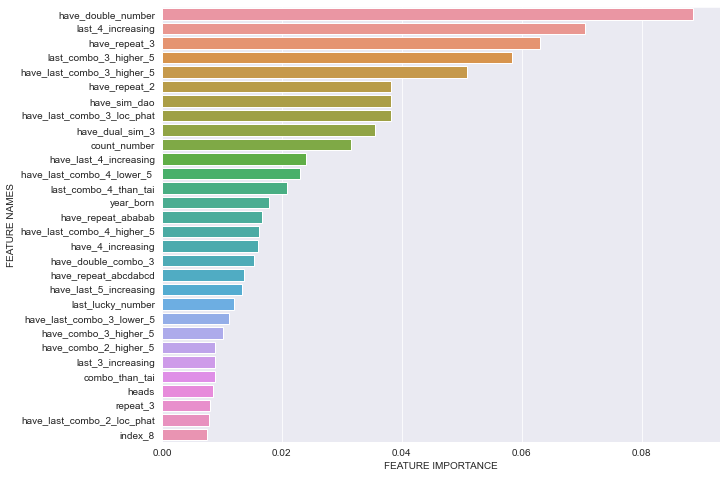

In [150]:
data={'feature_names':feature_names,'feature_importance':importances}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'][:30], y=fi_df['feature_names'][:30])
#Add chart labels
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')


In [151]:
y_pred = reg.predict(X_eval)

In [152]:
feature_extract = FeatureExtraction()
row_feature = feature_extract.feature_extract(str(567891279))
print(row_feature)
df_predict = pd.DataFrame([row_feature])

{'tele': 'vietnammobile', 'heads': '05', 'head_tele': '056', 'index_0': '0', 'index_1': '5', 'index_2': '6', 'index_3': '7', 'index_4': '8', 'index_5': '9', 'index_6': '1', 'index_7': '2', 'index_8': '7', 'index_9': '9', 'count_number': 7, 'have_last_combo_6_lower_5': 'no', 'last_combo_6_lower_5': '-1', 'have_combo_6_lower_5': 'no', 'combo_6_lower_5': '-1', 'have_last_combo_5_lower_4': 'no', 'last_combo_5_lower_4': '-1', 'have_combo_5_lower_4': 'no', 'combo_5_lower_4': '-1', 'have_last_combo_5_equal_4': 'no', 'last_combo_5_equal_4': '-1', 'have_combo_5_equal_4': 'no', 'combo_5_equal_4': '-1', 'have_last_combo_4_lower_5 ': 'no', 'last_combo_4_lower_5 ': '-1', 'have_combo_4_lower_5 ': 'no', 'combo_4_lower_5 ': '-1', 'have_last_combo_3_lower_5': 'no', 'last_combo_3_lower_5': '-1', 'have_combo_3_lower_5': 'no', 'combo_3_lower_5': '-1', 'have_last_combo_2_lower_5': 'no', 'last_combo_2_lower_5': '-1', 'have_combo_2_lower_5': 'no', 'combo_2_lower_5': '-1', 'have_last_combo_6_higher_5': 'no', 

In [153]:
df_predict

tele heads head_tele index_0 index_1 index_2 index_3 index_4  \
0  vietnammobile    05       056       0       5       6       7       8   

  index_5 index_6  ... have_double_combo_2_3 have_last_sim_ganh_dao  \
0       9       1  ...                    no                   khác   

  last_sim_ganh_dao  have_sim_ganh_dao sim_ganh_dao have_year_born year_born  \
0              khác               khác         khác             no        -1   

  have_sim_dao sim_dao dai_cat  
0           no      -1      no  

[1 rows x 143 columns]

In [154]:
for col in columns:
    try:
        df_predict[col] = encoder[col].transform(df_predict[col])
    except:
        print(col, df_predict[col])

In [155]:
reg.predict(df_predict)

array([0])

In [156]:
print(classification_report(np.array(y_eval), y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     33571
           1       0.86      0.79      0.82     19896

    accuracy                           0.87     53467
   macro avg       0.87      0.86      0.86     53467
weighted avg       0.87      0.87      0.87     53467



In [158]:
cm =  confusion_matrix(y_eval, y_pred)

In [159]:
cm

array([[31029,  2542],
       [ 4234, 15662]], dtype=int64)

In [ ]:
list_idx = []
label_true = 1
label_pred = 0
for idx in range(len(y_pred)):

    if y_pred[idx] == label_pred and y_eval.iloc[idx] == label_true:

        list_idx.append(idx)
X_test_cm = pd.DataFrame()
for col in columns:
    X_test_cm[col] = encoder[col].inverse_transform(X_eval[col])

test_X = X.loc[X_eval.iloc[list_idx].index]
test_X['predict'] = label_pred

for col in columns:
    test_X[col] = encoder[col].inverse_transform(test_X[col])
test_X

In [163]:
df_label_2

phone_number  price_vnd  label  label_2
0         929956939  1250000.0      2        1
1         835698567   750000.0      2        1
2         528898768   550000.0      2        1
3         834405505  1000000.0      2        1
4         368465111  1150000.0      2        1
...             ...        ...    ...      ...
356430    799681992  3900000.0      6        3
356433    818222278  4500000.0      6        3
356439    852571571  4000000.0      6        3
356440    869666808  4600000.0      6        3
356442    913913355  4000000.0      6        3

[270096 rows x 4 columns]

In [164]:
_t = Timer()
_t.start('start feature extraction')
list_dict = []
count = 0
for idx, row in df_label_2.iterrows():
    feature_extract = FeatureExtraction()
    row_feature = feature_extract.feature_extract(str(row['phone_number']))
    row_feature['phone_number'] = row['phone_number']
    row_feature['price'] = row['price_vnd']
    row_feature['label'] = row['label_2']
    list_dict.append(row_feature)
_t.stop()

[INFO] start feature extraction finished in 64.787 s.


In [165]:
list_dict

[{'tele': 'vietnammobile',
  'heads': '09',
  'head_tele': '092',
  'index_0': '0',
  'index_1': '9',
  'index_2': '2',
  'index_3': '9',
  'index_4': '9',
  'index_5': '5',
  'index_6': '6',
  'index_7': '9',
  'index_8': '3',
  'index_9': '9',
  'count_number': 5,
  'have_last_combo_6_lower_5': 'no',
  'last_combo_6_lower_5': '-1',
  'have_combo_6_lower_5': 'no',
  'combo_6_lower_5': '-1',
  'have_last_combo_5_lower_4': 'no',
  'last_combo_5_lower_4': '-1',
  'have_combo_5_lower_4': 'no',
  'combo_5_lower_4': '-1',
  'have_last_combo_5_equal_4': 'no',
  'last_combo_5_equal_4': '-1',
  'have_combo_5_equal_4': 'no',
  'combo_5_equal_4': '-1',
  'have_last_combo_4_lower_5 ': 'no',
  'last_combo_4_lower_5 ': '-1',
  'have_combo_4_lower_5 ': 'no',
  'combo_4_lower_5 ': '-1',
  'have_last_combo_3_lower_5': 'no',
  'last_combo_3_lower_5': '-1',
  'have_combo_3_lower_5': 'no',
  'combo_3_lower_5': '-1',
  'have_last_combo_2_lower_5': 'no',
  'last_combo_2_lower_5': '-1',
  'have_combo_2_lowe

In [166]:
_df_label = pd.DataFrame(list_dict)

In [167]:
columns = _df_label.columns

In [168]:
columns = [column for column in columns if column != 'phone_number' and column != 'price' and column != 'label']

In [169]:
from sklearn import preprocessing
encoder = {}
for col in columns:
    encoder[col] = preprocessing.LabelEncoder()
    print(col, _df_label[col].unique())
    encoder[col].fit(_df_label[col])
    _df_label[col] = encoder[col].transform(_df_label[col])

tele ['vietnammobile' 'vina' 'khác' 'viettel' 'mobi' 'gmobile']
heads ['09' '08' '05' '03' '07']
head_tele ['092' '083' '052' '036' '037' '033' '078' '034' '090' '096' '056' '086'
 '039' '091' '082' '088' '032' '087' '097' '089' '093' '094' '084' '076'
 '077' '081' '098' '070' '079' '085' '058' '038' '035' '099' '059' '055']
index_0 ['0']
index_1 ['9' '8' '5' '3' '7']
index_2 ['2' '3' '6' '7' '8' '4' '0' '9' '1' '5']
index_3 ['9' '5' '8' '4' '6' '3' '1' '7' '2' '0']
index_4 ['9' '6' '8' '4' '7' '3' '0' '1' '2' '5']
index_5 ['5' '9' '0' '6' '4' '3' '8' '2' '7' '1']
index_6 ['6' '8' '5' '0' '9' '1' '7' '4' '3' '2']
index_7 ['9' '5' '7' '1' '0' '8' '2' '4' '3' '6']
index_8 ['3' '6' '0' '1' '7' '8' '4' '9' '2' '5']
index_9 ['9' '7' '8' '5' '1' '4' '3' '2' '0' '6']
count_number [5 6 4 7 9 8 3 2]
have_last_combo_6_lower_5 ['no']
last_combo_6_lower_5 ['-1']
have_combo_6_lower_5 ['no']
combo_6_lower_5 ['-1']
have_last_combo_5_lower_4 ['no']
last_combo_5_lower_4 ['-1']
have_combo_5_lower_4 ['no

In [170]:
X, y = _df_label, _df_label['label']

In [171]:
params = {
    'max_depth': 9,
    'eta': 0.3,
    'learning_rate': 0.01
}

In [ ]:
from sklearn.metrics import mean_squared_error
X_train, X_eval, y_train, y_eval = train_test_split(X[columns], y, test_size=0.15 ,random_state=14)
reg =  xgb.XGBClassifier(learning_rate=0.15,max_depth=15, n_estimators=18)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_eval)

In [ ]:
print(classification_report(np.array(y_eval), y_pred))

In [ ]:
cm =  confusion_matrix(y_eval, y_pred)

In [ ]:
cm

In [110]:
list_idx = []
label_true = 1
label_pred = 1
for idx in range(len(y_pred)):
    if y_pred[idx] == label_pred and y_eval.iloc[idx] == label_true:
        list_idx.append(idx)
X_test_cm = pd.DataFrame()
for col in columns:

    X_test_cm[col] = encoder[col].inverse_transform(X_eval[col])

test_X = X.loc[X_eval.iloc[list_idx].index]
test_X['predict'] = label_pred

for col in columns:
    test_X[col] = encoder[col].inverse_transform(test_X[col])
test_X

tele heads head_tele index_0 index_1 index_2 index_3 index_4  \
57789            mobi    07       079       0       7       9       6       5   
120165           mobi    07       078       0       7       8       5       8   
97659   vietnammobile    09       092       0       9       2       2       2   
100838  vietnammobile    05       058       0       5       8       9       6   
142735        viettel    09       097       0       9       7       7       7   
...               ...   ...       ...     ...     ...     ...     ...     ...   
58985   vietnammobile    09       092       0       9       2       2       4   
73034            mobi    07       078       0       7       8       3       6   
52460   vietnammobile    09       092       0       9       2       8       3   
140086           mobi    07       078       0       7       8       3       3   
149036           vina    08       082       0       8       2       6       2   

       index_5 index_6  ... sim_ganh_dao have_year_born year_born  \
57789        8       3  ...         khác             no        -1   
120165       2       5  ...          858             no        -1   
97659        6       0  ...         khác             no        -1   
100838       8       3  ...         khác             no        -1   
142735       4       3  ...         khác             no        -1   
...        ...     ...  ...          ...            ...       ...   
58985        3       1  ...         khác             no        -1   
73034        1       1  ...         khác             no        -1   
52460        8       2  ...        28382             no        -1   
140086       1       1  ...         khác             no        -1   
149036       8       0  ...           -1             no        -1   

        have_sim_dao sim_dao dai_cat phone_number      price label predict  
57789            yes    3113      no    796583113  1100000.0     1       1  
120165            no      -1      no    785825968   700000.0     1       1  
97659             no      -1      no    922260168  1100000.0     1       1  
100838            no      -1      no    589683779  1250000.0     1       1  
142735            no      -1      no    977743193   800000.0     1       1  
...              ...     ...     ...          ...        ...   ...     ...  
58985             no      -1      no    922431839  1250000.0     1       1  
73034            yes    1551      no    783611551   700000.0     1       1  
52460            yes    2332      no    928382332  1100000.0     1       1  
140086           yes    1551      no    783311551  1350000.0     1       1  
149036            no      -1      no    826280575   650000.0     1       1  

[15291 rows x 147 columns]

Text(0, 0.5, 'FEATURE NAMES')

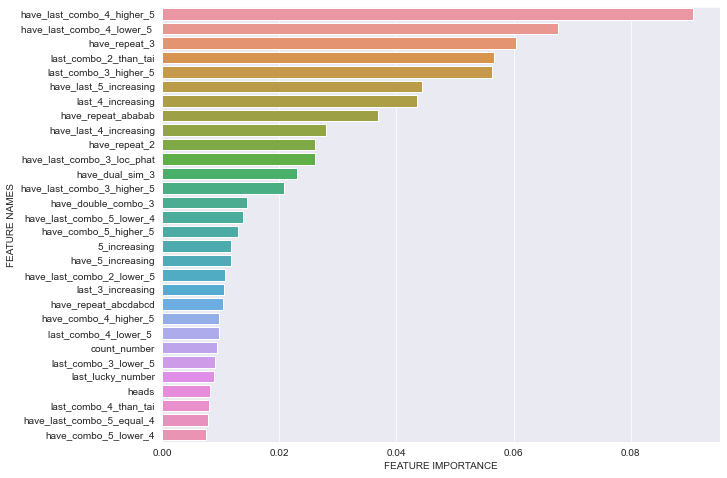

In [111]:
importances = reg.feature_importances_
indices = np.argsort(importances)
feature_names = np.array(columns)
data={'feature_names':feature_names,'feature_importance':importances}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'][:30], y=fi_df['feature_names'][:30])
#Add chart labels
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')


In [ ]:
print(mean_squared_error(y_eval, y_pred, squared=False))

In [ ]:
y_pred[65]

In [ ]:
y_eval.iloc[65]

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
label_kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X_train)

In [ ]:
df_X_train = X_train.copy()

In [ ]:
df_X_train['kmeans'] = label_kmeans

In [ ]:
df_X_train['kmeans'].value_counts()

In [ ]:
X[X['combo_5_lower_5'] != 4]

In [ ]:
test_X = df_.loc[X_test.index].copy()
for col in columns:
    test_X[col] = encoder[col].inverse_transform(X_test[col])

In [ ]:
test_X['predict'] = np.floor(y_pred)

In [ ]:
plt.hist(y_pred, bins=100)

In [ ]:
test_X

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
test_X['price'] = test_X['price']/1000

In [ ]:
test_X

In [ ]:
df_['price_vnd'].loc[test_X.index] = test_X['price']

In [ ]:
df_['price_vnd'][test_X.index]

In [ ]:
df_.to_csv('../data/train_data_1.csv',index=False)